In [1]:
%pylab inline
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import optimize
import statsmodels.formula.api as smf
import community

Populating the interactive namespace from numpy and matplotlib


In [2]:
june = pd.read_csv('2014-06 - Citi Bike trip data.csv')
stations = pd.read_csv('citibike-locations.csv')

In [3]:
# Converting starttime default data type to datetime
june['starttime'] = pd.to_datetime(june['starttime'])

# Extracting day and hour from starttime variable
june.loc[:,'Day'] = june['starttime'].dt.day
june.loc[:,'Hour'] = june['starttime'].dt.hour
june.loc[:,'weekDay'] = june['starttime'].dt.weekday

In [4]:
june['tripMins'] = june['tripduration']/60
june2014 = june[(june.tripMins>10) & (june.tripMins<60)]

In [5]:
june2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516121 entries, 6 to 936878
Data columns (total 19 columns):
tripduration               516121 non-null int64
starttime                  516121 non-null datetime64[ns]
stoptime                   516121 non-null object
start station id           516121 non-null int64
start station name         516121 non-null object
start station latitude     516121 non-null float64
start station longitude    516121 non-null float64
end station id             516121 non-null int64
end station name           516121 non-null object
end station latitude       516121 non-null float64
end station longitude      516121 non-null float64
bikeid                     516121 non-null int64
usertype                   516121 non-null object
birth year                 516121 non-null object
gender                     516121 non-null int64
Day                        516121 non-null int64
Hour                       516121 non-null int64
weekDay                    516121 

In [6]:
june2014.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Day,Hour,weekDay,tripMins
6,1280,2014-06-01 00:00:45,2014-06-01 00:22:05,168,W 18 St & 6 Ave,40.739713,-73.994564,341,Stanton St & Mangin St,40.717821,-73.976289,18766,Subscriber,1989,1,1,0,6,21.333333
7,973,2014-06-01 00:00:52,2014-06-01 00:17:05,453,W 22 St & 8 Ave,40.744751,-73.999154,447,8 Ave & W 52 St,40.763707,-73.985162,21391,Customer,\N,0,1,0,6,16.216667
10,1056,2014-06-01 00:00:58,2014-06-01 00:18:34,312,Allen St & E Houston St,40.722055,-73.989111,387,Centre St & Chambers St,40.712733,-74.004607,17182,Subscriber,1982,2,1,0,6,17.600000
12,1035,2014-06-01 00:01:15,2014-06-01 00:18:30,312,Allen St & E Houston St,40.722055,-73.989111,387,Centre St & Chambers St,40.712733,-74.004607,18146,Subscriber,1979,1,1,0,6,17.250000
14,605,2014-06-01 00:01:30,2014-06-01 00:11:35,252,MacDougal St & Washington Sq,40.732264,-73.998522,403,E 2 St & 2 Ave,40.725029,-73.990697,20205,Subscriber,1935,1,1,0,6,10.083333


### Getting station names

In [7]:
stations_name = june2014.groupby(['start station id', 'start station name']).count()
stations_name = stations_name.reset_index()

In [8]:
stations_name = stations_name[['start station id', 'start station name', 'tripduration']]
stations_name.columns = ['id', 'name', 'count']
stations_name.head()
print len(stations_name)
print stations_name

328
       id                             name  count
0      72                 W 52 St & 11 Ave   2226
1      79         Franklin St & W Broadway   1251
2      82           St James Pl & Pearl St    624
3      83    Atlantic Ave & Fort Greene Pl    731
4     116                  W 17 St & 8 Ave   2387
5     119         Park Ave & St Edwards St     88
6     120      Lexington Ave & Classon Ave    305
7     127            Barrow St & Hudson St   1155
8     128         MacDougal St & Prince St   2915
9     137            E 56 St & Madison Ave   1008
10    143        Clinton St & Joralemon St    550
11    144              Nassau St & Navy St    299
12    146             Hudson St & Reade St   1232
13    147         Greenwich St & Warren St   2714
14    150                E 2 St & Avenue C   1044
15    151         Cleveland Pl & Spring St   3675
16    152            Warren St & Church St   1011
17    153                  E 40 St & 5 Ave   1537
18    157          Henry St & Atlantic Ave    

## Overall Trends by Hour of the Day

In [9]:
grouped = june2014.groupby(['Day', 'Hour']).count()
grouped = grouped.reset_index()
grouped = grouped[['Day', 'Hour', 'tripduration']]
grouped.head()

,Day,Hour,tripduration
0,1,0,208
1,1,1,147
2,1,2,87
3,1,3,44
4,1,4,26


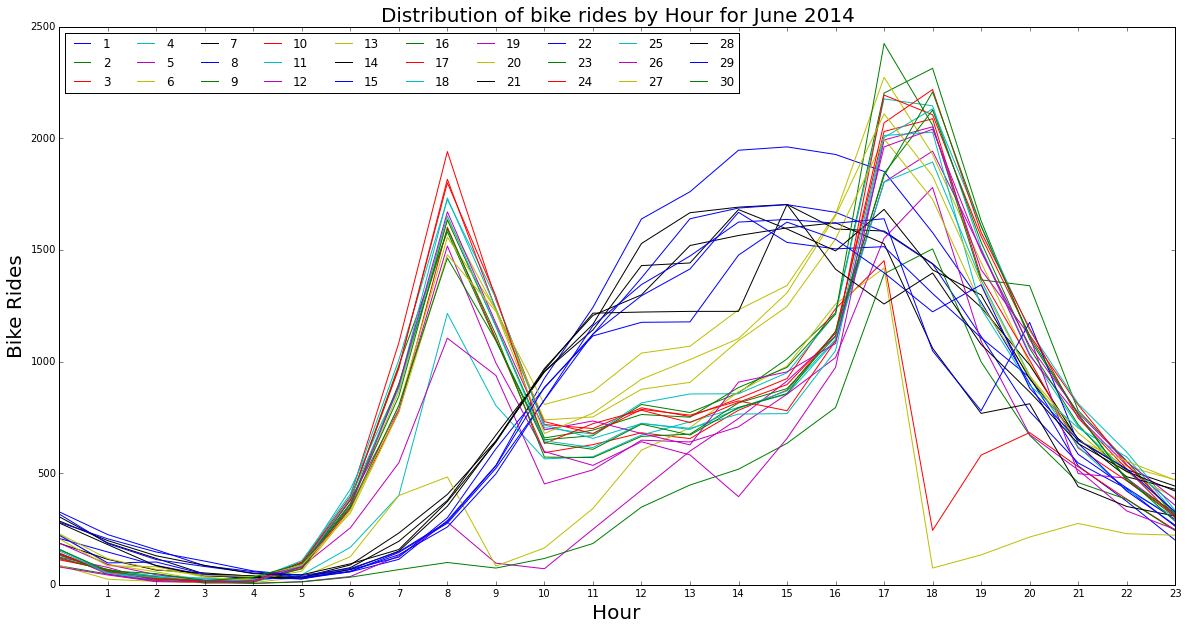

In [10]:
pivoted = pd.pivot_table(grouped, values='tripduration', columns='Day', index='Hour')
hours = range(1,24,1)
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
pivoted.plot(ax=ax).legend(loc='upper left', ncol=10)
ax.set_title("Distribution of bike rides by Hour for June 2014", fontsize='20')
ax.set_xlabel("Hour", fontsize='20')
ax.set_ylabel("Bike Rides", fontsize='20')
ax.set_xticks(hours)

## Weekend Trends by Hour of the Day

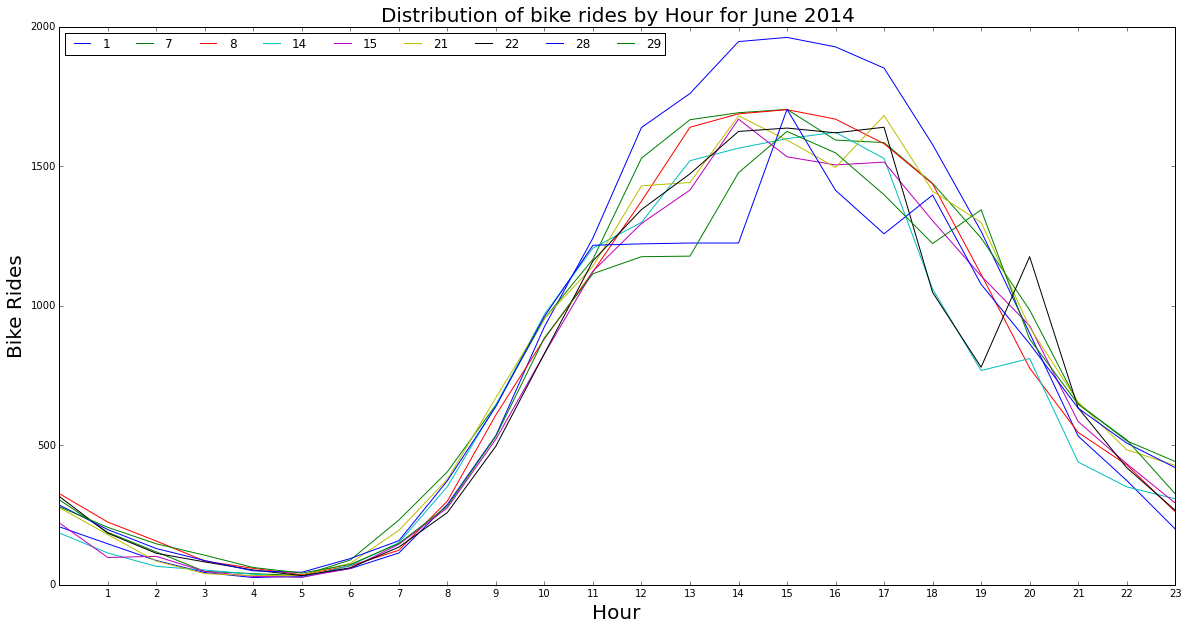

In [11]:
grouped = june2014[june2014.weekDay > 4].groupby(['Day', 'Hour']).count()
grouped = grouped.reset_index()
grouped = grouped[['Day', 'Hour', 'tripduration']]
grouped.head()

pivoted = pd.pivot_table(grouped, values='tripduration', columns='Day', index='Hour')
hours = range(1,24,1)
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
pivoted.plot(ax=ax).legend(loc='upper left', ncol=10)
ax.set_title("Distribution of bike rides by Hour for June 2014", fontsize='20')
ax.set_xlabel("Hour", fontsize='20')
ax.set_ylabel("Bike Rides", fontsize='20')
ax.set_xticks(hours)

## WeekDay Trends by Hour of the Day

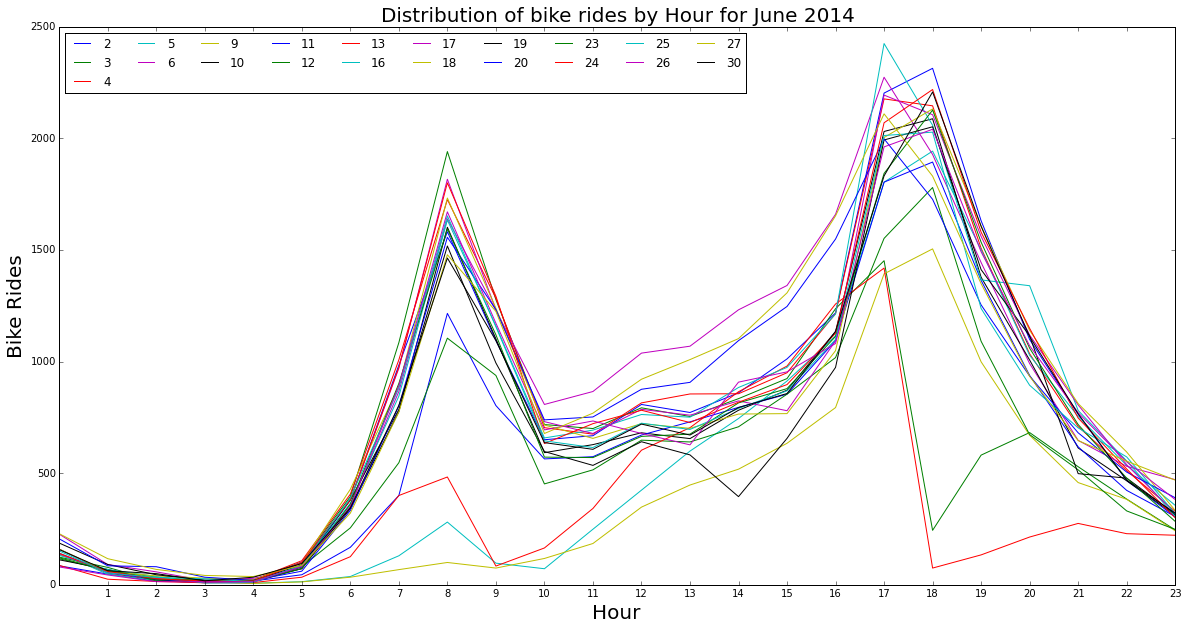

In [12]:
grouped = june2014[june2014.weekDay < 5].groupby(['Day', 'Hour']).count()
grouped = grouped.reset_index()
grouped = grouped[['Day', 'Hour', 'tripduration']]
grouped.head()

pivoted = pd.pivot_table(grouped, values='tripduration', columns='Day', index='Hour')
hours = range(1,24,1)
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
pivoted.plot(ax=ax).legend(loc='upper left', ncol=10)
ax.set_title("Distribution of bike rides by Hour for June 2014", fontsize='20')
ax.set_xlabel("Hour", fontsize='20')
ax.set_ylabel("Bike Rides", fontsize='20')
ax.set_xticks(hours)

## Divide the data into weekDay and weekEnd

In [13]:
weekDay = june2014[june2014.weekDay < 5]
weekEnd = june2014[june2014.weekDay > 4]

In [14]:
print weekDay.Hour.unique()
print weekEnd.Hour.unique()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


## Centrality measures across Hour of the Day - WeekEnd 

In [15]:
pos ={}
for c in stations.index:
    pos[stations.station_id[c]] = (stations.lon[c], stations.lat[c])

In [16]:
# Output top tn centrality scores, given the dictionary d    
def topdict(d,tn):
    ind=sorted(d, key=d.get, reverse=True)
    for i in range(0,tn):
       print('{0}|{1}:{2} {3}'.format(i+1,ind[i],d[ind[i]], stations_name[stations_name['id']==ind[i]]['name'].values[0]))

In [17]:
# Function for the graph with weighted edges
def networkGraphWE(data):
    averaged = data.groupby(['start station id', 'end station id']).count()
    averaged = averaged.reset_index()
    averaged = averaged[['start station id', 'end station id', 'tripduration']]
    averaged.columns = ['start', 'stop', 'weight']
    averaged = averaged[averaged['start'] != averaged['stop']]

    dataGraph = nx.DiGraph()
    for i in averaged.index:
        dataGraph.add_edge(averaged['start'][i], averaged['stop'][i], weight = 1.0*averaged['weight'][i]/9)
    return dataGraph

### Pagerank Centrality

In [18]:
for i in range(24):
    graph1 = networkGraphWE(weekEnd[weekEnd.Hour == i])
    c = nx.pagerank(graph1, 0.85)
    print("Top 10 nodes for Hour:{0}".format(i))
    topdict(c,10)

Top 10 nodes for Hour:0
1|401:0.0160103959153 Allen St & Rivington St
2|539:0.0113416620703 Metropolitan Ave & Bedford Ave
3|368:0.0109662965801 Carmine St & 6 Ave
4|445:0.0102139461246 E 10 St & Avenue A
5|426:0.00999975514838 West St & Chambers St
6|404:0.00990550301452 9 Ave & W 14 St
7|361:0.00943112930851 Allen St & Hester St
8|350:0.00932438195846 Clinton St & Grand St
9|236:0.00930966590597 St Marks Pl & 2 Ave
10|295:0.00927103584154 Pike St & E Broadway
Top 10 nodes for Hour:1
1|504:0.015088731246 1 Ave & E 15 St
2|426:0.0130251983548 West St & Chambers St
3|403:0.0124865771061 E 2 St & 2 Ave
4|3002:0.0122335229246 South End Ave & Liberty St
5|380:0.0106083770633 W 4 St & 7 Ave S
6|444:0.0101474950106 Broadway & W 24 St
7|476:0.0101210577578 E 31 St & 3 Ave
8|361:0.0100996694862 Allen St & Hester St
9|448:0.00920116000679 W 37 St & 10 Ave
10|161:0.00914379762241 LaGuardia Pl & W 3 St
Top 10 nodes for Hour:2
1|167:0.0148161741321 E 39 St & 3 Ave
2|515:0.0143083914696 W 43 St & 1

In [19]:
Hours = range(24)
pagerankOutputWE = {}
pagerankOutputWE = {x:{} for x in Hours} # Using dictionary comprehensions

for i in range(24):
    graph1 = networkGraphWE(weekEnd[weekEnd.Hour == i])
    c = nx.pagerank(graph1, 0.85)
    ind=sorted(c, key=c.get, reverse=True)
    for j in range(0,10):
        pagerankOutputWE[i][j] = ind[j]

## Centrality measures across Hour of the Day - WeekDay

### Pagerank Centrality

In [20]:
# Function for the graph with weighted edges
def networkGraphWD(data):
    averaged = data.groupby(['start station id', 'end station id']).count()
    averaged = averaged.reset_index()
    averaged = averaged[['start station id', 'end station id', 'tripduration']]
    averaged.columns = ['start', 'stop', 'weight']
    averaged = averaged[averaged['start'] != averaged['stop']]

    dataGraph = nx.DiGraph()
    for i in averaged.index:
        dataGraph.add_edge(averaged['start'][i], averaged['stop'][i], weight = 1.0*averaged['weight'][i]/21)
    return dataGraph

In [21]:
for i in range(24):
    graph1 = networkGraphWD(weekDay[weekDay.Hour == i])
    c = nx.pagerank(graph1, 0.85)
    print("Top 10 nodes for Hour:{0}".format(i))
    topdict(c,10)

Top 10 nodes for Hour:0
1|445:0.0149224623866 E 10 St & Avenue A
2|401:0.011575593607 Allen St & Rivington St
3|312:0.0103906686719 Allen St & E Houston St
4|380:0.00966953712043 W 4 St & 7 Ave S
5|361:0.00930619073836 Allen St & Hester St
6|265:0.00856219562017 Stanton St & Chrystie St
7|358:0.00846579853041 Christopher St & Greenwich St
8|323:0.00839526919671 Lawrence St & Willoughby St
9|453:0.00810766153191 W 22 St & 8 Ave
10|532:0.00798592981278 S 5 Pl & S 4 St
Top 10 nodes for Hour:1
1|504:0.0135720455892 1 Ave & E 15 St
2|401:0.0117273130294 Allen St & Rivington St
3|433:0.0115995072225 E 13 St & Avenue A
4|358:0.0105865255497 Christopher St & Greenwich St
5|311:0.0099757130995 Norfolk St & Broome St
6|445:0.00950953296918 E 10 St & Avenue A
7|3002:0.00942131282555 South End Ave & Liberty St
8|329:0.00919148811498 Greenwich St & N Moore St
9|539:0.00867091584722 Metropolitan Ave & Bedford Ave
10|512:0.00854549936318 W 29 St & 9 Ave
Top 10 nodes for Hour:2
1|532:0.0176201468059 S

In [22]:
Hours = range(24)
pagerankOutputWD = {}
pagerankOutputWD = {x:{} for x in Hours} # Using dictionary comprehensions

for i in range(24):
    graph1 = networkGraphWD(weekDay[weekDay.Hour == i])
    c = nx.pagerank(graph1, 0.85)
    ind=sorted(c, key=c.get, reverse=True)
    for j in range(0,10):
        pagerankOutputWD[i][j] = ind[j]

## Divide the data into three temporal segments
## WeekDay Morning 8 AM, WeekDay Evening 5-6 PM, WeekEnd Afternoon 2-5 PM

In [23]:
wkDYmorn = weekDay[weekDay.Hour == 8]
wkDYeven = weekDay[weekDay.Hour.isin([17,18])]
wkEDeven = weekEnd[weekEnd.Hour.isin([14,15,16,17])]

### Visualizing the Community Networks

In [24]:
# Remove loop edges from a network
def remove_loops(G):
    GU=G
    for n in GU.nodes():
        if GU.has_edge(n,n):
            GU.remove_edge(n,n)
    return GU  

In [25]:
# Produce symmetrized undirected version of a directed network
def as_undirected(G):
    GU=nx.Graph()
    for e in G.edges(data=True):
        if GU.has_edge(e[0],e[1]):
            GU[e[0]][e[1]]['weight']=GU[e[0]][e[1]]['weight']+e[2]['weight']
        else:
            GU.add_edge(e[0],e[1],weight=e[2]['weight'])
    return GU   

In [26]:
# Counting rides between each pair of the stations
wkDYmorn_grouped = wkDYmorn.groupby(['start station id', 'end station id']).count()
wkDYeven_grouped = wkDYeven.groupby(['start station id', 'end station id']).count()
wkEDeven_grouped = wkEDeven.groupby(['start station id', 'end station id']).count()

In [27]:
# Resetting the indeces
wkDYmorn_grouped = wkDYmorn_grouped.reset_index()
wkDYeven_grouped = wkDYeven_grouped.reset_index()
wkEDeven_grouped = wkEDeven_grouped.reset_index()

In [28]:
# Selecting 3 columns, representing node A, node B and weight of the edges
wkDYmorn_grouped = wkDYmorn_grouped[['start station id', 'end station id', 'tripduration']]
wkDYeven_grouped = wkDYeven_grouped[['start station id', 'end station id', 'tripduration']]
wkEDeven_grouped = wkEDeven_grouped[['start station id', 'end station id', 'tripduration']]
wkDYmorn_grouped.columns = ['start', 'stop', 'weight']
wkDYeven_grouped.columns = ['start', 'stop', 'weight']
wkEDeven_grouped.columns = ['start', 'stop', 'weight']
wkDYmorn_grouped = wkDYmorn_grouped[wkDYmorn_grouped['start'] != wkDYmorn_grouped['stop']]
wkDYeven_grouped = wkDYeven_grouped[wkDYeven_grouped['start'] != wkDYeven_grouped['stop']]
wkEDeven_grouped = wkEDeven_grouped[wkEDeven_grouped['start'] != wkEDeven_grouped['stop']]

In [29]:
# Creating the graphs
wkDYmorn_graph = nx.DiGraph()
wkDYeven_graph = nx.DiGraph()
wkEDeven_graph = nx.DiGraph()

# There are 9 weekends and 21 weekday in June, 2014
# Adding edges
for k in wkDYmorn_grouped.index:
    wkDYmorn_graph.add_edge(wkDYmorn_grouped['start'][k], wkDYmorn_grouped['stop'][k], weight = 1.0*wkDYmorn_grouped['weight'][k]/21)
for k in wkDYeven_grouped.index:
    wkDYeven_graph.add_edge(wkDYeven_grouped['start'][k], wkDYeven_grouped['stop'][k], weight = 1.0*wkDYeven_grouped['weight'][k]/21)
for k in wkEDeven_grouped.index:
    wkEDeven_graph.add_edge(wkEDeven_grouped['start'][k], wkEDeven_grouped['stop'][k], weight = 1.0*wkEDeven_grouped['weight'][k]/9)

In [30]:
wkDYmorn_graph = remove_loops(wkDYmorn_graph)
wkDYeven_graph = remove_loops(wkDYeven_graph)
wkEDeven_graph = remove_loops(wkEDeven_graph)

wkDYmorn_graph = as_undirected(wkDYmorn_graph)
wkDYeven_graph = as_undirected(wkDYeven_graph)
wkEDeven_graph = as_undirected(wkEDeven_graph)

wkDYmorn_communities = community.best_partition(wkDYmorn_graph)
wkDYeven_communities = community.best_partition(wkDYeven_graph)
wkEDeven_communities = community.best_partition(wkEDeven_graph)

In [31]:
wkDYmorn_pagerank = nx.pagerank(wkDYmorn_graph, 0.85)
wkDYeven_pagerank = nx.pagerank(wkDYeven_graph, 0.85)
wkEDeven_pagerank = nx.pagerank(wkEDeven_graph, 0.85)

In [32]:
# Visualizing function
def visualizePartition(G, partition, pgrank, pos):
    labels = {}   
    N=len(G.nodes())
    s=4+4*int(log10(N))
    plt.figure(figsize=(s,s))
    PN=max(partition.values())
    my_cmap = matplotlib.cm.hsv(np.linspace(0,1,PN+1)) #create a colormap for a given number of communities
    c=[]
    for n in G.nodes():
        c.append(1.0*partition[n]/PN)
        if 1.5E5*pgrank[n] > 1000:
            #set the node name as the key and the label as its value 
            labels[n] = n
    n_size = 1.5E5*np.array(pgrank.values())
    for i in range(0, len(n_size)):
        if n_size[i] <1000:
            n_size[i] = 100
            
    nx.draw(G, pos=pos, with_labels=False, arrows=True, node_size=n_size, 
            node_color=c, width=0.5, style='dotted',edge_color='green')
#     nx.draw_networkx_labels(G,pos,labels)
#     print(1.5E5*np.array(pgrank.values()))
#     mplleaflet.display()

/home/bibby/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


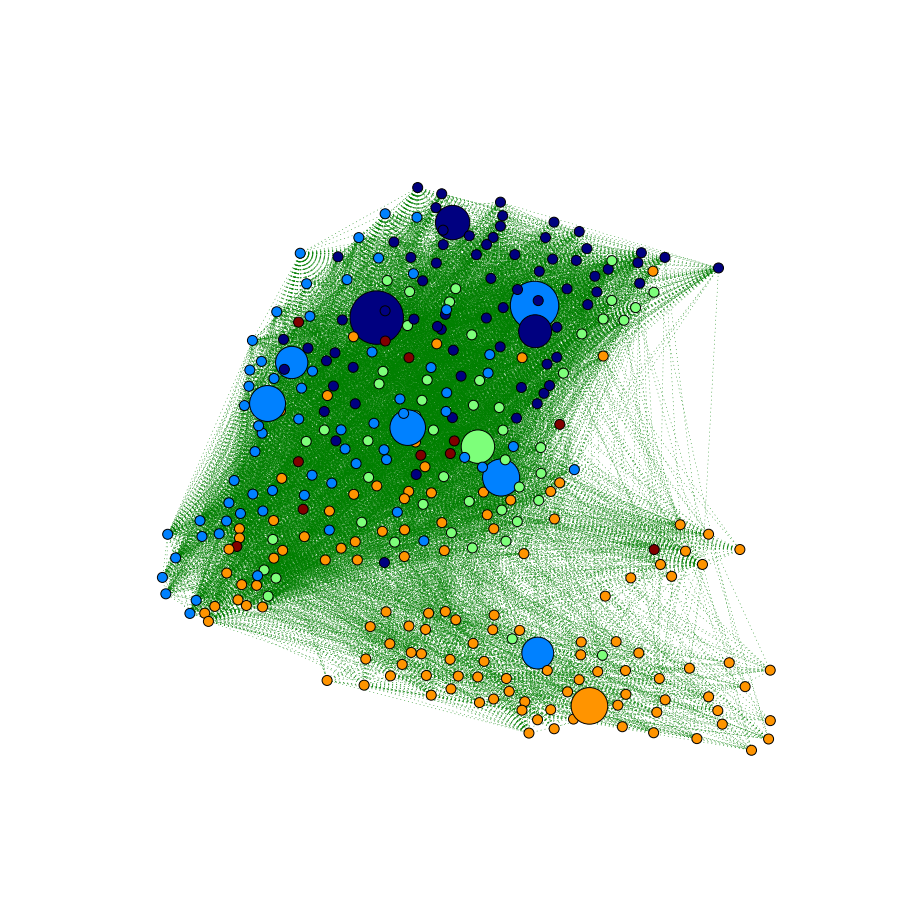

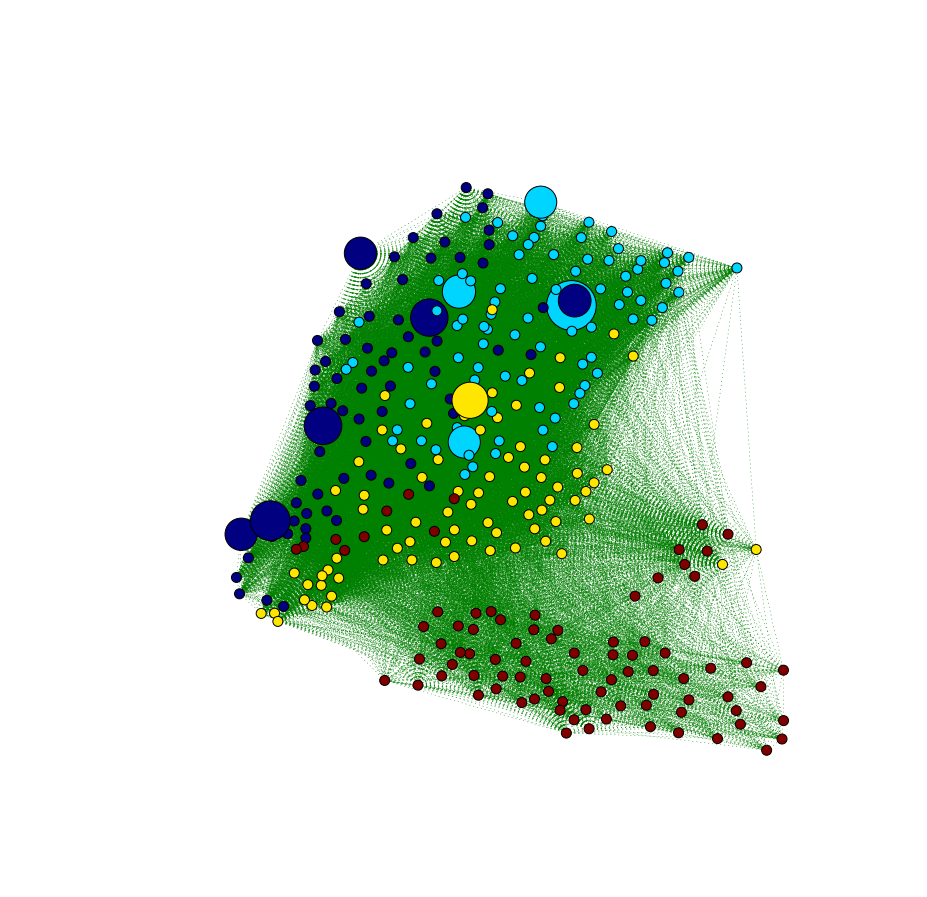

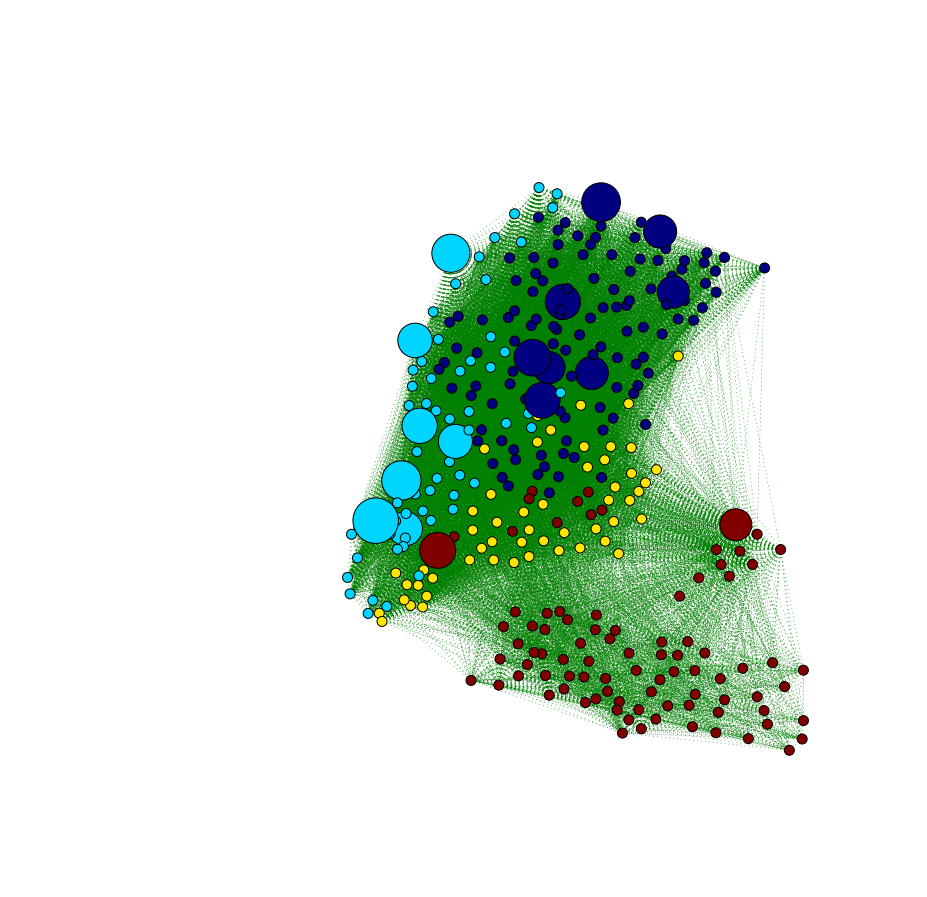

In [33]:
# Plotting the communities
random.seed(2015)
visualizePartition(wkDYmorn_graph, wkDYmorn_communities, wkDYmorn_pagerank, pos)

random.seed(2015)
visualizePartition(wkDYeven_graph, wkDYeven_communities, wkDYeven_pagerank, pos)

random.seed(2015)
visualizePartition(wkEDeven_graph, wkEDeven_communities, wkEDeven_pagerank, pos)

In [41]:
unique(wkDYmorn_communities.values())

array([0, 1, 2, 3, 4])

In [42]:
# Splitting the graphs into communities for wkDYmorn
group0 = []
group1 = []
group2 = []
group3 = []
group4 = []

for k in wkDYmorn_communities:
    if wkDYmorn_communities[k] == 0:
        group0.append(k)
    if wkDYmorn_communities[k] == 1:
        group1.append(k)
    if wkDYmorn_communities[k] == 2:
        group2.append(k)
    if wkDYmorn_communities[k] == 3:
        group3.append(k)
    if wkDYmorn_communities[k] == 4:
        group4.append(k)

wkDYmorn_graph0 = wkDYmorn_graph.subgraph(group0)
wkDYmorn_graph1 = wkDYmorn_graph.subgraph(group1)
wkDYmorn_graph2 = wkDYmorn_graph.subgraph(group2)
wkDYmorn_graph3 = wkDYmorn_graph.subgraph(group3)
wkDYmorn_graph4 = wkDYmorn_graph.subgraph(group4)

In [43]:
unique(wkDYeven_communities.values())

array([0, 1, 2, 3])

In [44]:
# Splitting the graphs into communities for wkDYeven
group0 = []
group1 = []
group2 = []
group3 = []

for k in wkDYeven_communities:
    if wkDYeven_communities[k] == 0:
        group0.append(k)
    if wkDYeven_communities[k] == 1:
        group1.append(k)
    if wkDYeven_communities[k] == 2:
        group2.append(k)
    if wkDYeven_communities[k] == 3:
        group3.append(k)

wkDYeven_graph0 = wkDYeven_graph.subgraph(group0)
wkDYeven_graph1 = wkDYeven_graph.subgraph(group1)
wkDYeven_graph2 = wkDYeven_graph.subgraph(group2)
wkDYeven_graph3 = wkDYeven_graph.subgraph(group3)

In [45]:
unique(wkEDeven_communities.values())

array([0, 1, 2, 3])

In [36]:
# Splitting the graphs into communities for wkEDeven
group0 = []
group1 = []
group2 = []
group3 = []

for k in wkEDeven_communities:
    if wkEDeven_communities[k] == 0:
        group0.append(k)
    if wkEDeven_communities[k] == 1:
        group1.append(k)
    if wkEDeven_communities[k] == 2:
        group2.append(k)
    if wkEDeven_communities[k] == 3:
        group3.append(k)

wkEDeven_graph0 = wkEDeven_graph.subgraph(group0)
wkEDeven_graph1 = wkEDeven_graph.subgraph(group1)
wkEDeven_graph2 = wkEDeven_graph.subgraph(group2)
wkEDeven_graph3 = wkEDeven_graph.subgraph(group3)

In [46]:
# Calculating pageranks for each community inside each temporal dimension
print "WeekDay Morning community 0"
topdict(nx.pagerank(wkDYmorn_graph0, 0.85), 5)
print "\n"
print "WeekDay Evening community 0"
topdict(nx.pagerank(wkDYeven_graph0, 0.85), 5)
print "\n\n"
print "WeekEnd Evening community 0"
topdict(nx.pagerank(wkEDeven_graph0, 0.85), 5)

WeekDay Morning community 0
1|521:0.0754264813092 8 Ave & W 31 St
2|490:0.028823282934 8 Ave & W 33 St
3|318:0.0284823061825 E 43 St & Vanderbilt Ave
4|305:0.0250594099111 E 58 St & 3 Ave
5|359:0.0245610192606 E 47 St & Park Ave


WeekDay Evening community 0
1|426:0.045801741173 West St & Chambers St
2|358:0.0325540031455 Christopher St & Greenwich St
3|521:0.0275423107804 8 Ave & W 31 St
4|327:0.0251093525996 Vesey Pl & River Terrace
5|514:0.0248755300548 12 Ave & W 40 St



WeekEnd Evening community 0
1|499:0.0307353807712 Broadway & W 60 St
2|281:0.0289411440788 Grand Army Plaza & Central Park S
3|2006:0.0228435799254 Central Park S & 6 Ave
4|457:0.0216168650021 Broadway & W 58 St
5|497:0.0203347385959 E 17 St & Broadway


In [47]:
# Calculating pageranks for each community inside each temporal dimension
print "WeekDay Morning community 1"
topdict(nx.pagerank(wkDYmorn_graph1, 0.85), 5)
print "\n"
print "WeekDay Evening community 1"
topdict(nx.pagerank(wkDYeven_graph1, 0.85), 5)
print "\n\n"
print "WeekEnd Evening community 1"
topdict(nx.pagerank(wkEDeven_graph1, 0.85), 5)

WeekDay Morning community 1
1|519:0.0497796777496 E 42 St & Vanderbilt Ave
2|426:0.0340282288983 West St & Chambers St
3|358:0.0315207538312 Christopher St & Greenwich St
4|327:0.028023026939 Vesey Pl & River Terrace
5|347:0.0278116218169 W Houston St & Hudson St


WeekDay Evening community 1
1|519:0.0418551155354 E 42 St & Vanderbilt Ave
2|492:0.0268439449259 W 33 St & 7 Ave
3|523:0.0234146269985 W 38 St & 8 Ave
4|499:0.0231932047287 Broadway & W 60 St
5|498:0.0219304593354 Broadway & W 32 St



WeekEnd Evening community 1
1|426:0.0587974653883 West St & Chambers St
2|327:0.0436240598448 Vesey Pl & River Terrace
3|514:0.0409449415427 12 Ave & W 40 St
4|225:0.0315325570636 W 14 St & The High Line
5|459:0.0306681988051 W 20 St & 11 Ave


In [48]:
# Calculating pageranks for each community inside each temporal dimension
print "WeekDay Morning community 2"
topdict(nx.pagerank(wkDYmorn_graph2, 0.85), 5)
print "\n"
print "WeekDay Evening community 2"
topdict(nx.pagerank(wkDYeven_graph2, 0.85), 5)
print "\n\n"
print "WeekEnd Evening community 2"
topdict(nx.pagerank(wkEDeven_graph2, 0.85), 5)

WeekDay Morning community 2
1|465:0.0400635235216 Broadway & W 41 St
2|523:0.0373260222386 W 38 St & 8 Ave
3|518:0.0342716181511 E 39 St & 2 Ave
4|497:0.031429848447 E 17 St & Broadway
5|435:0.0306174744236 W 21 St & 6 Ave


WeekDay Evening community 2
1|501:0.0269766470163 FDR Drive & E 35 St
2|497:0.0268550385984 E 17 St & Broadway
3|315:0.0248717974698 South St & Gouverneur Ln
4|518:0.0214234794296 E 39 St & 2 Ave
5|351:0.0210461288158 Front St & Maiden Ln



WeekEnd Evening community 2
1|315:0.0437215922262 South St & Gouverneur Ln
2|151:0.0356227154805 Cleveland Pl & Spring St
3|259:0.0355347987305 South St & Whitehall St
4|501:0.0353844464909 FDR Drive & E 35 St
5|285:0.0346269661968 Broadway & E 14 St


In [49]:
# Calculating pageranks for each community inside each temporal dimension
print "WeekDay Morning community 3"
topdict(nx.pagerank(wkDYmorn_graph3, 0.85), 5)
print "\n"
print "WeekDay Evening community 3"
topdict(nx.pagerank(wkDYeven_graph3, 0.85), 5)
print "\n\n"
print "WeekEnd Evening community 3"
topdict(nx.pagerank(wkEDeven_graph3, 0.85), 5)

WeekDay Morning community 3
1|417:0.038781935697 Barclay St & Church St
2|259:0.0245978414105 South St & Whitehall St
3|387:0.024457230576 Centre St & Chambers St
4|2000:0.0214626419811 Front St & Washington St
5|151:0.0198384595618 Cleveland Pl & Spring St


WeekDay Evening community 3
1|387:0.0430403080931 Centre St & Chambers St
2|2000:0.0328364397155 Front St & Washington St
3|417:0.0274456905612 Barclay St & Church St
4|412:0.0258264477022 Forsyth St & Canal St
5|2002:0.0255256412285 Wythe Ave & Metropolitan Ave



WeekEnd Evening community 3
1|2002:0.048226363135 Wythe Ave & Metropolitan Ave
2|387:0.0382149398943 Centre St & Chambers St
3|539:0.0370761413549 Metropolitan Ave & Bedford Ave
4|532:0.0298459461772 S 5 Pl & S 4 St
5|398:0.0289113520763 Atlantic Ave & Furman St


In [51]:
print "WeekEnd Evening community 4"
topdict(nx.pagerank(wkDYmorn_graph4, 0.85), 5)

WeekEnd Evening community 4
1|388:0.157381588016 W 26 St & 10 Ave
2|466:0.149212705575 W 25 St & 6 Ave
3|319:0.118304985222 Park Pl & Church St
4|128:0.101982709893 MacDougal St & Prince St
5|237:0.0891324192501 E 11 St & 2 Ave
